## Object Detection Model training using YOLO
References - 
- [Documentation](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/#13-prepare-dataset-for-yolov5)
- [Testing IoU](https://stackoverflow.com/questions/77565416/how-to-test-iou-score-after-training-a-yolo-model)
- [IoU calculation](https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation)
- [Hungarian Algorithm to match Bounding Boxes](https://gist.github.com/AruniRC/c629c2df0e68e23aff7dcaeef87c72d4)

In [2]:
# Import necessary libraries
import numpy as np
import os, sys 
import matplotlib.pyplot as plt
from ultralytics import YOLO
import fiftyone as fo 
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import json, shutil 
from collections import defaultdict
from itertools import product 
from functools import reduce
from scipy.optimize import linear_sum_assignment
import cv2

np.random.seed(0)
# Save to current directory
curr_dir = os.getcwd()

/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
fo.config.dataset_zoo_dir = curr_dir

# Download the data
# By default, the following loads data for detections
dataset = foz.load_zoo_dataset("coco-2017", 
                            splits=['train'],
                            shuffle=True,
                            seed=0,
                            max_samples=5000,
                            label_types=['detections'],
                            only_matching=True,
                            classes=['person'])

Found annotations at '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-5000'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [3]:
# Load the downloaded dataset
coco_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path='coco-2017/train/data',
    labels_path='coco-2017/train/labels.json',
    max_samples=5000,
    include_id=True,
)

 100% |███████████████| 5000/5000 [1.3m elapsed, 0s remaining, 57.6 samples/s]      


In [ ]:
# The above downloads all classes in COCO
# We filter them to only have people using the following - 
coco_dataset.export(
    labels_path="coco-2017/labels.json",
    dataset_type=fo.types.COCODetectionDataset,
    classes=['person'],
)

In [4]:
# We need to convert the dataset to YOLO format
input_dir = curr_dir + "/coco-2017/"
output_dir = curr_dir + "/yolo/"

images_folder = input_dir + "train/data/"


if not os.path.exists(output_dir):
	os.mkdir(output_dir)

for split in ['train', 'test']:
	shutil.rmtree(output_dir + split, ignore_errors=True)
	os.mkdir(output_dir + split)
	os.mkdir(output_dir + split + '/images')
	os.mkdir(output_dir + split + '/labels')

In [15]:

ground_truths = defaultdict(list)

# Read the annotations
with open(input_dir + 'labels.json', 'r') as f:
		data = json.load(f)

# Count number of annotations
num_data = len(data['images'])
print(f"Total number of images are {num_data}")

# Choose 80-20 split
num_train = np.floor(0.8*num_data)
num_test = np.floor(0.2*num_data)
print(num_train, num_test) 

# Match annotations to images and write in YOLO format
count = 0

id_ann = defaultdict(list)
for ann in data['annotations']:
	id_ann[ann['image_id']].append(ann)

for image in data['images']:
	width = image['width']
	height = image['height']
	filename = image['file_name'].split('.')[0]
	id = image['id']

	
	# Writing current object and copying image
	if count < num_train:
		split = 'train'
	else:
		split = 'test'
	
	f = open(f'{output_dir}{split}/labels/{filename}.txt', 'w')

	for annotation in id_ann[id]:
		current_category = annotation['category_id']
		x, y, w, h = annotation['bbox']
		
		# Finding midpoints
		x_centre = x + w/2
		y_centre = y + h/2
		
		# Normalization
		x_centre /= width
		y_centre /= height
		w /= width
		h /= height
		
		# Limiting upto fix number of decimal places
		sx_centre = format(x_centre, '.6f')
		sy_centre = format(y_centre, '.6f')
		sw = format(w, '.6f')
		sh = format(h, '.6f')


		ground_truths[image['file_name']].append([x_centre, y_centre, w, h])
		
		f.write(f"{current_category} {sx_centre} {sy_centre} {sw} {sh}\n")
	f.close()
	shutil.copy(images_folder + image['file_name'], f'{output_dir}{split}/images/{filename}.jpg')	
	count += 1

Total number of images are 5000
4000.0 1000.0


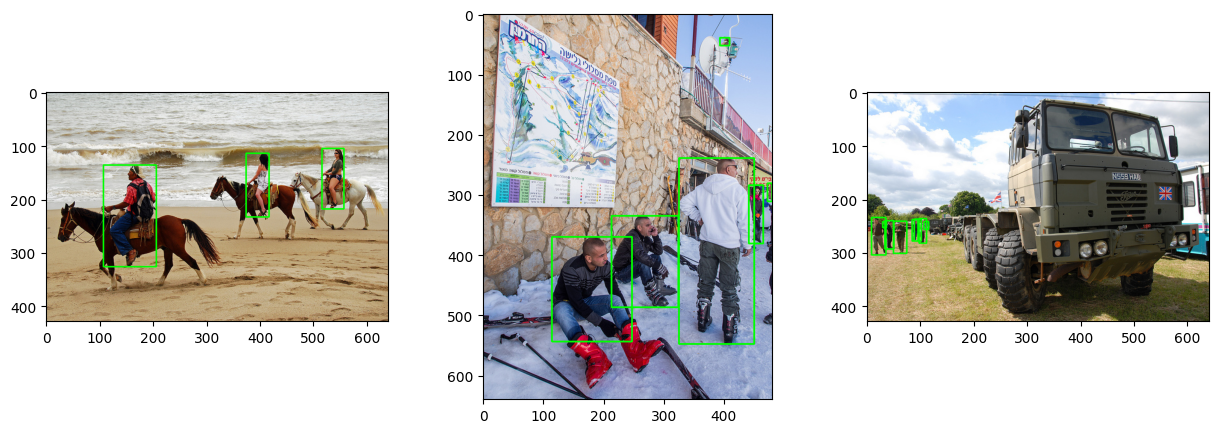

In [21]:
# Sample an image from the dataset for credibility
train_images = os.listdir(images_folder)
random_images = np.random.choice(train_images, 3)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, file in enumerate(random_images):
    img = cv2.imread(images_folder + file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    anns = ground_truths[file]
    for ann in anns:
        start = (int((ann[0] - ann[2]/2)*w), int((ann[1] - ann[3]/2)*h))
        end = (int((ann[0] + ann[2]/2)*w), int((ann[1] + ann[3]/2)*h))
        img = cv2.rectangle(img, start, end, (0, 255, 0), 2)
    ax[i].imshow(img)

In [97]:
# Load model for training
model = YOLO('yolov5nu.pt')

In [12]:
# Train the model
# Device = mps is for Apple Silicon
train_results = model.train(data='config.yaml', batch=16, epochs=10, plots=True, device='mps')

New https://pypi.org/project/ultralytics/8.1.45 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.8.16 torch-1.13.1 CPU (Apple M1 Pro)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov5nu.pt, data=config.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train25, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

train: Scanning /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/train/labels.cache... 3995 images, 0 backgrounds, 5 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/train/images/000000187302.jpg: ignoring corrupt image/label: image file is truncated (12 bytes not processed)
train: WARNING ⚠️ /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/train/images/000000215994.jpg: ignoring corrupt image/label: cannot identify image file '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/train/images/000000215994.jpg'
train: WARNING ⚠️ /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/train/images/000000285826.jpg: ignoring corrupt image/label: image file is truncated (17 bytes not processed)
train: WARNING ⚠️ /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/train/images/000000376407.jpg: ignoring corrupt image/label: cannot identify image file '/Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/train/images/


val: Scanning /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/labels.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]

Plotting labels to /opt/homebrew/runs/detect/train25/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /opt/homebrew/runs/detect/train25
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G       1.35      1.814      1.295         42        640: 100%|██████████| 250/250 [3:02:35<00:00, 43.82s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:05<00:00,  5.78s/it]

                   all       1000       4065      0.593      0.439      0.477      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.621      1.721      1.491         38        640: 100%|██████████| 250/250 [28:35<00:00,  6.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:08<00:00,  5.90s/it]

                   all       1000       4065      0.536       0.45      0.462      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.672        1.7      1.538         61        640: 100%|██████████| 250/250 [29:52<00:00,  7.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:07<00:00,  5.85s/it]

                   all       1000       4065      0.573      0.406      0.448      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.628      1.604      1.514         44        640: 100%|██████████| 250/250 [28:48<00:00,  6.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:04<00:00,  5.76s/it]

                   all       1000       4065      0.617      0.441      0.491       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.591      1.546      1.476         49        640: 100%|██████████| 250/250 [28:33<00:00,  6.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:04<00:00,  5.77s/it]

                   all       1000       4065      0.595      0.442      0.485      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G       1.55      1.483      1.446         27        640: 100%|██████████| 250/250 [29:31<00:00,  7.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:10<00:00,  5.95s/it]

                   all       1000       4065      0.637      0.471      0.536      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.494      1.416      1.414         27        640: 100%|██████████| 250/250 [29:33<00:00,  7.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:13<00:00,  6.05s/it]

                   all       1000       4065       0.68      0.503      0.574      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.446      1.346      1.373         43        640: 100%|██████████| 250/250 [28:40<00:00,  6.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:08<00:00,  5.90s/it]

                   all       1000       4065      0.719      0.514      0.599      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.373      1.261       1.33         39        640: 100%|██████████| 250/250 [6:25:48<00:00, 92.60s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [1:40:31<00:00, 188.48s/it]  

                   all       1000       4065      0.746      0.523      0.626      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.327      1.206        1.3         42        640: 100%|██████████| 250/250 [5:58:25<00:00, 86.02s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:06<00:00,  5.83s/it]

                   all       1000       4065      0.709       0.55      0.632      0.389



10 epochs completed in 20.986 hours.
Optimizer stripped from /opt/homebrew/runs/detect/train25/weights/last.pt, 5.2MB
Optimizer stripped from /opt/homebrew/runs/detect/train25/weights/best.pt, 5.2MB

Validating /opt/homebrew/runs/detect/train25/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.8.16 torch-1.13.1 CPU (Apple M1 Pro)
YOLOv5n summary (fused): 193 layers, 2503139 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [02:56<00:00,  5.51s/it]


                   all       1000       4065      0.711       0.55      0.633      0.389
Speed: 0.8ms preprocess, 170.0ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /opt/homebrew/runs/detect/train25


In [13]:
# Save the model
model.save(filename='trained.pt')

In [98]:
# Load model from trained weights
model.load('trained.pt')

Transferred 427/427 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3(
        (cv1): Conv(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_st

In [99]:
def calc_iou(bb1, bb2):
    b1_x1 = bb1[0] - bb1[2]/2
    b1_x2 = bb1[0] + bb1[2]/2
    b1_y1 = bb1[1] - bb1[3]/2
    b1_y2 = bb1[1] + bb1[3]/2

    b2_x1 = bb2[0] - bb2[2]/2
    b2_x2 = bb2[0] + bb2[2]/2
    b2_y1 = bb2[1] - bb2[3]/2
    b2_y2 = bb2[1] + bb2[3]/2

    # determine the coordinates of the intersection rectangle
    x_left = max(b1_x1, b2_x1)
    y_top = max(b1_y1, b2_y1)
    x_right = min(b1_x2, b2_x2)
    y_bottom = min(b1_y2, b2_y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = bb1[2]*bb1[3]
    bb2_area = bb2[2]*bb2[3]

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [100]:
# Test the data with IOU score 
test_images_folder = output_dir + 'test/images/'
test_labels_folder = output_dir + 'test/labels'
test_files = os.listdir(test_images_folder)
sum_iou = 0
ious = defaultdict(float)
num_test = len(test_files)

# Create a folder to save the results
results_folder = output_dir + 'results/'
if not os.path.exists(results_folder):
	os.mkdir(results_folder)
    
# Iterate through the test files to test the performance
for test_file in test_files:
    res = model.predict(test_images_folder + test_file, classes=[0])
    res[0].save(results_folder + test_file)
    
    gt = ground_truths[test_file]
    preds = res[0].boxes.xywhn.numpy()
    
    if len(gt) == 0 or len(preds) == 0:
         continue
    
    combinations = list(product(gt, preds))
    iou_matrix = np.zeros((len(gt), len(preds)))
    for i in range(len(gt)):
        for j in range(len(preds)):
            iou_matrix[i, j] = calc_iou(gt[i], preds[j])

    # Do the Hungarian matching algorithm
    gt_idx, pred_idx = linear_sum_assignment(1 - iou_matrix)
    assigned_ious = np.sort(iou_matrix[gt_idx, pred_idx])[-len(gt):]
    
    # Compute mean across all instances in the image
    mean_iou = np.mean(assigned_ious)

    assert mean_iou <= 1.0 
    
    sum_iou += mean_iou
    ious[test_file] = (mean_iou, assigned_ious)


image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000520047.jpg: 448x640 3 persons, 78.8ms
Speed: 1.6ms preprocess, 78.8ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000536619.jpg: 480x640 7 persons, 59.8ms
Speed: 1.0ms preprocess, 59.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000566984.jpg: 480x640 12 persons, 59.5ms
Speed: 1.1ms preprocess, 59.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000499763.jpg: 640x448 1 person, 60.1ms
Speed: 1.2ms preprocess, 60.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /Users/su

In [101]:
# Calculate the mean across all test cases
print("The average IoU across all test instances is", sum_iou/num_test)

The average IoU across all test instances is 0.7619198520725794



image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000463823.jpg: 480x640 1 person, 61.1ms
Speed: 1.0ms preprocess, 61.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000530925.jpg: 448x640 3 persons, 54.8ms
Speed: 0.9ms preprocess, 54.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000503663.jpg: 640x480 1 person, 61.9ms
Speed: 1.2ms preprocess, 61.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /Users/sudhansh/Desktop/Projects/Machine Learning Practice/Object Detection/yolo/test/images/000000551260.jpg: 512x640 1 person, 71.4ms
Speed: 1.3ms preprocess, 71.4ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /Users/sudha

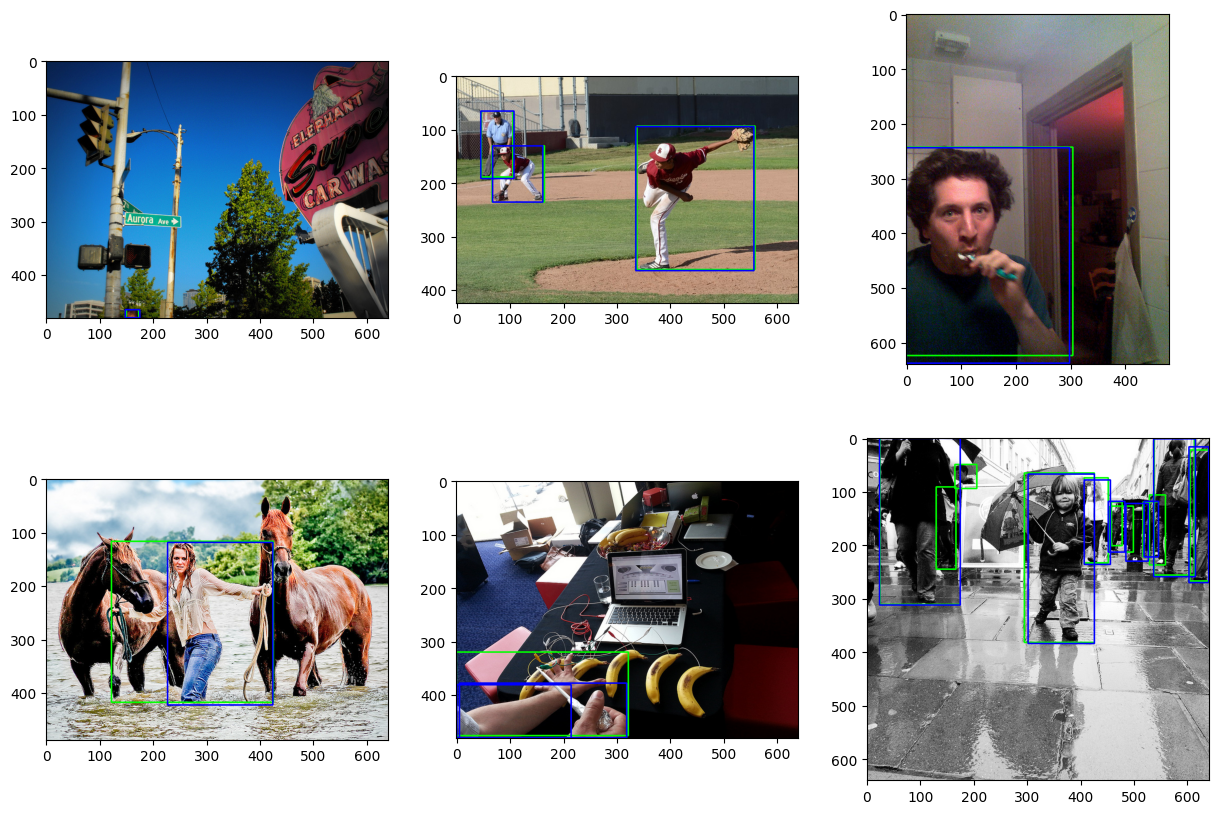

In [107]:
# Show some sample output results
n_samples = 6
random_tests = np.random.choice(test_files, n_samples)

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, test_file in enumerate(random_tests):
    res = model.predict(test_images_folder + test_file, classes=[0])
    preds = res[0].boxes.xywhn.numpy()
    img = cv2.imread(test_images_folder + test_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    anns = ground_truths[test_file]
    for ann in anns:
        start = (int((ann[0] - ann[2]/2)*w), int((ann[1] - ann[3]/2)*h))
        end = (int((ann[0] + ann[2]/2)*w), int((ann[1] + ann[3]/2)*h))
        img = cv2.rectangle(img, start, end, (0, 255, 0), 2)
    
    for ann in preds:
        start = (int((ann[0] - ann[2]/2)*w), int((ann[1] - ann[3]/2)*h))
        end = (int((ann[0] + ann[2]/2)*w), int((ann[1] + ann[3]/2)*h))
        img = cv2.rectangle(img, start, end, (0, 0, 255), 2)

    ax[i // 3][i % 3].imshow(img)